# Adapting Behavior via Intrinsic Reward: A Survey and Empirical Study
## Experiments 2 & 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
%matplotlib inline

This notebook is adapted from [the Adapting Behavior via Intrinsic Reward: a Survey and Empirical Study Drifter Distractor notebook](http://jair.adaptingbehavior.com/). In this notebook, we implement experiments 2 and 3 and try to reproduce the results from [the research paper](https://arxiv.org/pdf/1906.07865.pdf).

## Experiment Two: Switched Drifter-Distractor Problem
This section implements Experiment Two: Switched Drifter-Distractor Problem from the paper. See section 7 and 9 for a description.

In [20]:
def generate_action_data_two(switch=50_000, num_steps=150_000):
    num_steps_left = num_steps - switch
    # For the distractors each step is a random number chosen from a Normal distribution mean 0.0, var 1.0
    target1 = np.random.randn(switch)
    target4 = np.random.randn(switch)

    # Constant number randomly chosen between [-50, 50]
    target3 = np.ones(switch) * np.random.uniform(-50, 50)

    # At each step the drifter changes slightly by mean 0.0 and variance 0.1
    random_drift = np.random.randn(switch) * 0.1
    target2 = np.cumsum(random_drift)


    # Switch

    # At each step after switch, the drifter changes slightly
    # by variance 0.1
    random_drift1 = np.random.randn(num_steps_left) * 0.1
    random_drift2 = np.random.randn(num_steps_left) * 0.1
    drifter1 = np.cumsum(random_drift1) + target1[-1]
    drifter2 = np.cumsum(random_drift2) + target3[-1]

    # At each step after switch, for the distractors is a random number chosen
    # from a Normal distribution mean of last value of the target before switch, var 1.0
    distractor = np.random.randn(num_steps_left) + target2[-1]

    # At each step after switch, the constant is 0
    constant = np.zeros(num_steps_left) + target4[-1]

    target1 = np.concatenate((target1, drifter1))
    target2 = np.concatenate((target2, distractor))
    target3 = np.concatenate((target3, drifter2))
    target4 = np.concatenate((target4, constant))


    return np.array([target1, target2, target3, target4])

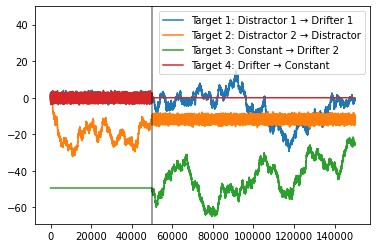

In [24]:
plt.plot(generate_action_data_two().T)
plt.axvline(x=50_000, alpha=0.5, color="black")
y_b, y_t = plt.ylim()
plt.ylim(min(-50, y_b), max(50, y_t))
plt.legend(["Target 1: Distractor 1 → Drifter 1",
            "Target 2: Distractor 2 → Distractor",
            "Target 3: Constant → Drifter 2",
            "Target 4: Drifter → Constant"])

## Setup
The setup is the same as the original notebook except for some minor changes in the last two cells.

In [4]:
class Autostep():
    def __init__(self, alpha=1.0, n=1.0, h=0.0, k=0.1):
        self.alpha = alpha
        self.n = n
        self.h = h
        self.k = k

    def update(self, delta):
        self.n = max(np.abs(delta * self.h), 
                     self.n + (1.0/10000.0) * self.alpha * (np.abs(delta * self.h) - self.n))

        self.alpha = min(self.alpha * np.exp(self.k * delta * self.h / self.n), 0.5)
        self.h = self.h * (1 - self.alpha) + (self.alpha * delta)
        return self.alpha, self.h, self.n

In [5]:
class MovingAverage:

    def __init__(self, beta=0.001, one=0.0, method="window"):
        self.avg = 0.0

        # for time based moving average
        self.t = 0

        # for windowed moving average
        self.one = one
        self.beta = beta

        self.method = method

    def update(self, x):

        if self.method == "window":
            self.one = ((1.0 - self.beta) * self.one) + (self.beta * 1.0)
            rate = self.beta / self.one
            self.avg = ((1.0 - rate) * self.avg) + (rate * x)

        if self.method == "time":
            self.t += 1
            self.avg += (x - self.avg) / self.t

        return self.avg

class IncrementalVariance:

    def __init__(self, beta=0.001, one=0.0, method="window"):
        self.sample_mean = MovingAverage(beta=beta, one=one, method=method)
        self.moving_variance = MovingAverage(beta=beta, one=one, method=method)
        self.type = method
        self.differences = []


    def update(self, x):

        old_mean = self.sample_mean.avg

        # update mean
        self.sample_mean.update(x)

        # update variance
        var_sample = (x - old_mean) * (x - self.sample_mean.avg)

        self.moving_variance.update(var_sample)

        return self.moving_variance.avg

In [6]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def select_action(probs):
    return np.random.choice(4, p=probs)

In [7]:
class IntrinsicReward:
    def __init__(self):
        self.prediction = 0.0
        self.stepsize = 0.0
        self.autostep_learner = None
        self.is_introspective = None

    def update_prediction(self, x):
        delta = x - self.prediction

        if self.is_introspective:
            self.autostep_learner.update(delta)
            stepsize = self.autostep_learner.alpha
        else:
            stepsize = self.stepsize

        self.prediction += stepsize * delta

        return delta

class ErrorDerivative(IntrinsicReward):
    def __init__(self, stepsize=0.03125, is_introspective=False, **kwargs):
        self.stepsize = stepsize
        self.is_introspective = is_introspective
        self.eta = kwargs.get("eta", 1000)
        self.tau = kwargs.get("tau", 100)
        self.squared_errors = []
        self.prediction = 0.0

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):

        delta = self.update_prediction(x)

        self.squared_errors.append(np.square(delta))
        length = len(self.squared_errors)     

        if length > (self.eta + self.tau + 1):
            first = (1.0 / (self.eta + 1)) * np.sum(self.squared_errors[-(self.eta+self.tau+1):-self.tau])
            second = (1.0 / (self.eta + 1)) * np.sum(self.squared_errors[-(self.eta+1):])
            return np.abs(first - second)
        else:
            return 0.0

class ExpectedError(IntrinsicReward):
    def __init__(self, stepsize=0.0625, is_introspective=False, **kwargs):
        self.stepsize = stepsize
        self.is_introspective = is_introspective
        self.one = 0.0
        self.beta = kwargs.get("beta", 0.01)
        self.delta_bar = 0.0
        self.prediction = 0.0

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        self.one = (1.0 - self.beta) * self.one + self.beta * 1.0
        rate = self.beta / self.one
        self.delta_bar = (1.0 - rate) * self.delta_bar + rate * delta

        return np.abs(self.delta_bar)

class StepSizeChange(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.previous_stepsize = 0.0
        self.is_introspective = is_introspective

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        if self.is_introspective:
            stepsize = self.autostep_learner.alpha
        else:
            stepsize = 0.0

        stepsize_change = np.abs(self.previous_stepsize - stepsize)
        self.previous_stepsize = stepsize

        return stepsize_change

class ErrorReduction(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.previous_error = 0.0

        self.is_introspective = is_introspective

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)
        im_reward = np.abs(self.previous_error) - np.abs(delta)
        self.previous_error = delta

        return im_reward

class SquaredError(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.stepsize = stepsize
        self.is_introspective = is_introspective

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        return np.square(delta)

class BayesianSurprise(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.stepsize = stepsize
        self.is_introspective = is_introspective

        self.previous_prediction = 0.0
        self.previous_variance = 0.0
        self.eta = 1.0
        self.b = kwargs.get("beta", 0.01)

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        self.b = 0.01
        self.eta = (1 - self.b) * self.eta + 1.0

        welfords_var = (1 - self.b) * self.previous_variance + self.b * (x - self.previous_prediction) * \
            (x - self.prediction)
        var = max(welfords_var / self.eta, 10**-2)

        if var != 0.0 and self.previous_variance != 0.0:
            first = 0.5 * np.log2(var / self.previous_variance)
            second = self.previous_variance + np.square(self.previous_prediction - self.prediction) / (2 * var)
            im_reward = first + second - 0.5
        else:
            im_reward = 0.0

        self.previous_variance = np.copy(var)
        self.previous_prediction = np.copy(self.prediction)

        return im_reward

class UDE(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.stepsize = stepsize
        self.is_introspective = is_introspective

        self.one = 0.0
        self.beta = kwargs.get("beta", 0.01)
        self.delta_bar = 0.0

        self.count = 0

        self.delta_squared_avg = MovingAverage(method="time")
        self.delta_avg = MovingAverage(method="time")

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        self.count += 1
        delta = self.update_prediction(x)

        self.one = (1.0 - self.beta) * self.one + self.beta * 1.0
        rate = self.beta / self.one
        self.delta_bar = (1.0 - rate) * self.delta_bar + rate * delta

        s_bar = self.delta_squared_avg.update(np.square(delta))
        x_bar = self.delta_avg.update(delta)

        if self.count > 30:
            count = self.delta_avg.t
            denom = np.sqrt((s_bar / count) - np.square(x_bar / count))
            im_reward = np.abs(self.delta_bar / (denom + 0.00001))
        else:
            im_reward = 0.0

        return im_reward

class UncertaintyChange(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.stepsize = stepsize
        self.is_introspective = is_introspective

        self.beta = kwargs.get("beta_var", 0.001)

        self.variance = IncrementalVariance(beta=self.beta)
        self.previous_variance = 0.0

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        var = self.variance.update(self.prediction)
        im_reward = np.abs(self.previous_variance - var)
        self.previous_varaiance = var

        return im_reward

class VarianceOfPrediction(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.stepsize = stepsize
        self.is_introspective = is_introspective

        self.variance = IncrementalVariance()

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        im_reward = self.variance.update(self.prediction)

        return im_reward

class WeightChange(IntrinsicReward):
    def __init__(self, stepsize=0.1, is_introspective=False, **kwargs):
        super().__init__()
        self.stepsize = stepsize
        self.is_introspective = is_introspective

        if self.is_introspective:
            self.autostep_learner = Autostep()

    def update(self, x):
        delta = self.update_prediction(x)

        if self.is_introspective:
            self.stepsize = self.autostep_learner.alpha

        return np.abs(self.stepsize * delta)

In [10]:
def choose_reward(name, is_introspective):
    if name == "Error Derivative":
        if is_introspective:
            return (ErrorDerivative(stepsize=1.0,
                                    is_introspective=True),
                    0.007812,
                    {"beta_r": 0.1,
                     "eta": 1000,
                     "tau": 1})
        else:
            return (ErrorDerivative(stepsize=0.03125,
                                   is_introspective=False),
                    0.25,
                    {"beta_r": 0.001,
                     "eta": 1000,
                     "tau": 100})

    elif name == "Expected Error":
        if is_introspective:
            return (ExpectedError(stepsize=1.0,
                                  is_introspective=True),
                    0.007812,
                    {"beta_r": 0.00001,
                     "beta": 0.001})
        else:
            return (ExpectedError(stepsize=0.0625,
                                  is_introspective=False),
                    0.125,
                    {"beta_r": 0.1,
                     "beta": 0.1})

    elif name == "Step-size Change":
        if is_introspective:
            return (StepSizeChange(stepsize=1.0,
                                  is_introspective=True),
                    0.25,
                    {"beta_r": 0.001})
        else:
            return (StepSizeChange(stepsize=0.1,
                                  is_introspective=False),
                    0.1,
                    {"beta_r": 0.001})

    elif name == "Error Reduction":
        if is_introspective:
            return (ErrorReduction(stepsize=1.0,
                                   is_introspective=True),
                    0.007812,
                    {"beta_r": 0.1})
        else:
            return (ErrorReduction(stepsize=0.125,
                                   is_introspective=False),
                    0.007812,
                    {"beta_r": 0.1})

    elif name == "Squared Error":
        if is_introspective:
            return (SquaredError(stepsize=1.0,
                                 is_introspective=True),
                    0.007812,
                    {"beta_r": 0.1})
        else:
            return (SquaredError(stepsize=0.015625,
                                 is_introspective=False),
                    0.015625,
                    {"beta_r": 0.01})

    elif name == "Bayesian Surprise":
        if is_introspective:
            return (BayesianSurprise(stepsize=1.0,
                                     is_introspective=True),
                    0.007812,
                    {"beta_r": 0.1,
                     "beta": 0.01})
        else:
            return (BayesianSurprise(stepsize=0.125,
                                     is_introspective=False),
                    0.007812,
                    {"beta_r": 0.0001,
                     "beta": 0.01})

    elif name == "UDE":
        if is_introspective:
            return (UDE(stepsize=1.0,
                        is_introspective=True),
                    0.007812,
                    {"beta_r": 0.1,
                     "beta": 0.01})
        else:
            return (UDE(stepsize=0.0625,
                        is_introspective=False),
                    0.125,
                    {"beta_r": 0.1,
                     "beta": 0.1})

    elif name == "Uncertainty Change":
        if is_introspective:
            return (UncertaintyChange(stepsize=1.0,
                                      is_introspective=True),
                    0.0625,
                    {"beta_r": 0.1,
                     "beta_var": 0.1})
        else:
            return (UncertaintyChange(stepsize=0.0625,
                                      is_introspective=False),
                    0.25,
                    {"beta_r": 0.01,
                     "beta_var": 0.01})

    elif name == "Variance of Prediction":
        if is_introspective:
            return (VarianceOfPrediction(stepsize=1.0,
                                         is_introspective=True),
                    0.007812,
                    {"beta_r": 0.1})
        else:
            return (VarianceOfPrediction(stepsize=0.125,
                                         is_introspective=False),
                    0.007812,
                    {"beta_r": 0.1})

    elif name == "Weight Change":
        if is_introspective:
            return (WeightChange(stepsize=1.0,
                                 is_introspective=True),
                    0.007812,
                    {"beta_r": 0.01})
        else:
            return (WeightChange(stepsize=0.0625,
                                 is_introspective=False),
                    0.007812,
                    {"beta_r": 0.1})

In [11]:
class BehaviorAgent:
    def __init__(self, behavior_stepsize, intrinsic_reward, is_introspective, *args, **kwargs):
        self.intrinsic_rewards = [choose_reward(intrinsic_reward, is_introspective)[0] for _ in range(4)]
        self.one = 0.0
        self.r_bar = 0.0
        self.beta = kwargs.get("beta_r", 0.1)
        self.behavior_stepsize = behavior_stepsize
        self.action_values = np.zeros(4)
        self.probs = np.ones(4) / 4

    def calculate_probs(self):
        self.probs = softmax(self.action_values)

    def choose_action(self):
        self.calculate_probs()
        return select_action(self.probs)

    def update(self, x, chosen_action):
        # get intrinsic_reward
        im_reward = self.intrinsic_rewards[chosen_action].update(x)

        # update_average_reward
        self.one = (1.0 - self.beta) * self.one + self.beta * 1.0
        rate = self.beta / self.one
        self.r_bar = (1.0 - rate) * self.r_bar + rate * im_reward

        # Update the actions values based on the intrinsic reward
        for action in range(4):
            self.action_values[action] += self.behavior_stepsize * (im_reward - self.r_bar) * \
                ((action==chosen_action) * 1.0 - self.probs[action])

In [12]:
def run_experiment(experiment_data=generate_action_data_two,
                   is_introspective=True, record_stepsizes=False,
                   intrinsic_reward="Error Derivative"):
    data = experiment_data()
    track_probs = []
    track_stepsizes = []

    behavior_agent = BehaviorAgent(choose_reward(intrinsic_reward, is_introspective)[1], 
                                   intrinsic_reward,
                                   is_introspective,
                                   **choose_reward(intrinsic_reward, is_introspective)[2])

    for i, step_data in enumerate(data.T):
        chosen_action = behavior_agent.choose_action()

        behavior_agent.update(step_data[chosen_action], chosen_action)

        track_probs.append(np.copy(behavior_agent.probs))

        if record_stepsizes:
            track_stepsizes.append(np.copy(np.array([learner.autostep_learner.alpha \
                                                     for learner in behavior_agent.intrinsic_rewards])))

    return np.array(track_probs), np.array(track_stepsizes)

In [27]:
def run():
    output = widgets.Output()
    button = widgets.Button(description="Run Experiment")


    choose_experiment = widgets.Dropdown(
        options=["Experiment Two", "Experiment Three"],
        value="Experiment Two",
        description="Choose Experiment:",
        disabled=False,
        style={'description_width': 'initial'},
    )

    choose_reward = widgets.Dropdown(
        options=["Error Derivative", "Expected Error", "Step-size Change", 
                "Error Reduction", "Squared Error", "Bayesian Surprise", 
                "UDE", "Uncertainty Change", "Variance of Prediction", "Weight Change"],
        value="Weight Change",
        description="Choose Reward:",
        disabled=False,
        style={'description_width': 'initial'},
    )

    choose_runs = widgets.IntText(description="Choose number of runs:", value=2, style={'description_width': 'initial'})
    choose_introspective = widgets.Checkbox(value=True, description="Use Introspective Learners?")

    def reset_displays():
        clear_output()
        display(choose_experiment)
        display(choose_reward)
        display(choose_runs)
        display(choose_introspective)
        display(button)

    def on_button_click(b):
        reset_displays()
        if choose_experiment.value == "Experiment Two":
            experiment = generate_action_data_two
        elif choose_experiment.value == "Experiment Three":
            pass
        reward = choose_reward.value
        print("Running")
        runs = [run_experiment(experiment_data=experiment, intrinsic_reward=reward, \
                               is_introspective=choose_introspective.value)[0] for _ in range(choose_runs.value)]
        action_probs = np.mean(runs, axis=0)
        with output:
            plt.figure(figsize=(4,5))
            colors = ["red", "black", "blue", "green"]
            for i in range(4):
                plt.plot(action_probs.T[i], color=colors[i])
            plt.axvline(x=50_000, alpha=0.5, color="black")
            plt.legend(["Distractor 1", "Distractor 2", "Constant", "Drifter"])
            plt.ylim([0.0, 1.0])

    button.on_click(on_button_click)
    reset_displays()

Dropdown(description='Choose Experiment:', options=('Experiment Two', 'Experiment Three'), style=DescriptionSt…

Dropdown(description='Choose Reward:', index=9, options=('Error Derivative', 'Expected Error', 'Step-size Chan…

IntText(value=2, description='Choose number of runs:', style=DescriptionStyle(description_width='initial'))

Checkbox(value=True, description='Use Introspective Learners?')

Button(description='Run Experiment', style=ButtonStyle())

Running


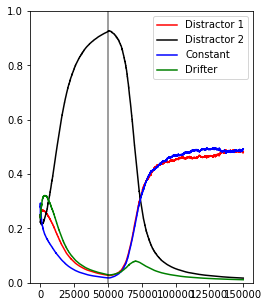

In [28]:
run()